This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage
import sys
import time

path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT 726-419 Spring 2021 A2` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT726-419Spring2021A2"

import sys
sys.path.insert(1, path_prefix)

Mounted at /content/gdrive


## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [3]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                ############################
                self.encoder = nn.Sequential(
                  nn.Linear(28*28, 1024), # N,784 -> N,1024
                  nn.ReLU(),
                  nn.Linear(1024, 2) # N,1024 -> N,2
                )
                
            def forward(self, x):
                # needs your implementation
                ############################
                # print (x.shape)
                x_batch = x.shape[0] # Store the first dimension of x
                # Reshape the input
                # print (x.reshape(x_batch,28*28).shape)
                # self.encoder(torch.reshape(x,(x_batch,28*28)))
                return self.encoder(torch.reshape(x,(x_batch,28*28)))
                
        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                ############################
                self.decoder = nn.Sequential(
                  nn.Linear(2, 1024), # N,2 -> N,1024
                  nn.ReLU(),
                  nn.Linear(1024, 28*28), # N,1024 -> N,784
                  nn.Sigmoid()
                )
                
            def forward(self, z):
                # needs your implementation
                ############################
                temp = self.decoder(z)
                # print ("z'shape: ", z.shape)
                z_batch = temp.shape[0] # Store the first dimension of z
                # print ("z's shape", z.reshape(z_batch,1,28,28).shape)
                return torch.reshape(temp,(z_batch,1,28,28))

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [ ]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder = Autoencoder(dim_latent_representation=2)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT 726-419 Spring 2021 A2` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT726-419Spring2021A2"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

In [ ]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
scatter_plot(latent_representations=z,labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


In [ ]:
with torch.no_grad():
    samples = torch.randn(7, 2).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

In [ ]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

In [ ]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [00:54<00:00, 34.44it/s]

====> Epoch: 1 Average loss: 0.7067



100%|██████████| 313/313 [00:03<00:00, 104.28it/s]

====> Val set loss (reconstruction error) : 0.6955



100%|██████████| 1875/1875 [01:01<00:00, 30.63it/s]

====> Epoch: 2 Average loss: 0.6833



100%|██████████| 313/313 [00:02<00:00, 104.83it/s]

====> Val set loss (reconstruction error) : 0.6913



100%|██████████| 1875/1875 [01:06<00:00, 28.06it/s]

====> Epoch: 3 Average loss: 0.6792



100%|██████████| 313/313 [00:03<00:00, 102.63it/s]

====> Val set loss (reconstruction error) : 0.6894



100%|██████████| 1875/1875 [01:08<00:00, 27.41it/s]

====> Epoch: 4 Average loss: 0.6762



100%|██████████| 313/313 [00:03<00:00, 103.54it/s]

====> Val set loss (reconstruction error) : 0.6847



100%|██████████| 1875/1875 [01:11<00:00, 26.23it/s]

====> Epoch: 5 Average loss: 0.6736



100%|██████████| 313/313 [00:03<00:00, 104.19it/s]

====> Val set loss (reconstruction error) : 0.6826



100%|██████████| 1875/1875 [01:18<00:00, 23.80it/s]

====> Epoch: 6 Average loss: 0.6716



100%|██████████| 313/313 [00:02<00:00, 105.35it/s]

====> Val set loss (reconstruction error) : 0.6816



100%|██████████| 1875/1875 [01:24<00:00, 22.11it/s]

====> Epoch: 7 Average loss: 0.6705



100%|██████████| 313/313 [00:02<00:00, 105.16it/s]

====> Val set loss (reconstruction error) : 0.6812



100%|██████████| 1875/1875 [01:29<00:00, 21.05it/s]

====> Epoch: 8 Average loss: 0.6692



100%|██████████| 313/313 [00:03<00:00, 103.71it/s]

====> Val set loss (reconstruction error) : 0.6796



100%|██████████| 1875/1875 [01:28<00:00, 21.16it/s]

====> Epoch: 9 Average loss: 0.6685



100%|██████████| 313/313 [00:03<00:00, 104.01it/s]

====> Val set loss (reconstruction error) : 0.6807



100%|██████████| 1875/1875 [01:27<00:00, 21.33it/s]

====> Epoch: 10 Average loss: 0.6677



100%|██████████| 313/313 [00:03<00:00, 104.09it/s]


====> Val set loss (reconstruction error) : 0.6786


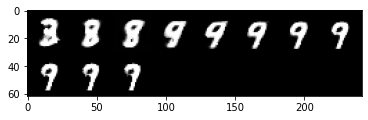

In [10]:
# Question 2 part e using the model from part (b)

images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

# print (images[0].shape)

# Create a model and train it
from autoencoder_starter import Autoencoder_Trainer
LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder1 = Autoencoder(dim_latent_representation=2)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder1,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")
        
from autoencoder_starter import display_images_in_a_row
interpolate_0 = autoencoder1.decoder((0*autoencoder1.encoder(images[0])) + (1-0)*autoencoder1.encoder(images[1]))
interpolate_1 = autoencoder1.decoder((0.1*autoencoder1.encoder(images[0])) + (1-0.1)*autoencoder1.encoder(images[1]))
interpolate_2 = autoencoder1.decoder((0.2*autoencoder1.encoder(images[0])) + (1-0.2)*autoencoder1.encoder(images[1]))
interpolate_3 = autoencoder1.decoder((0.3*autoencoder1.encoder(images[0])) + (1-0.3)*autoencoder1.encoder(images[1]))
interpolate_4 = autoencoder1.decoder((0.4*autoencoder1.encoder(images[0])) + (1-0.4)*autoencoder1.encoder(images[1]))
interpolate_5 = autoencoder1.decoder((0.5*autoencoder1.encoder(images[0])) + (1-0.5)*autoencoder1.encoder(images[1]))
interpolate_6 = autoencoder1.decoder((0.6*autoencoder1.encoder(images[0])) + (1-0.6)*autoencoder1.encoder(images[1]))
interpolate_7 = autoencoder1.decoder((0.7*autoencoder1.encoder(images[0])) + (1-0.7)*autoencoder1.encoder(images[1]))
interpolate_8 = autoencoder1.decoder((0.8*autoencoder1.encoder(images[0])) + (1-0.8)*autoencoder1.encoder(images[1]))
interpolate_9 = autoencoder1.decoder((0.9*autoencoder1.encoder(images[0])) + (1-0.9)*autoencoder1.encoder(images[1]))
interpolate_10 = autoencoder1.decoder((1*autoencoder1.encoder(images[0])) + (1-1)*autoencoder1.encoder(images[1]))

display_images_in_a_row(torch.cat((interpolate_0, interpolate_1, interpolate_2, interpolate_3, interpolate_4, interpolate_5, interpolate_6, interpolate_7, interpolate_8, interpolate_9, interpolate_10),0).cpu())